In [7]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [8]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()

## Task 1. Fourier Transform
In this task, we will show a useful property of the Fourier
Transform, which is the convolution property. It tells us that convolution in the
spatial domain corresponds to multiplication in the frequency domain. The input
image that you will be operating on is orange.jpeg and celeb.jpeg.

* Load the two images orange.jpeg and celeb.jpeg. Remember to convert to
grayscale.

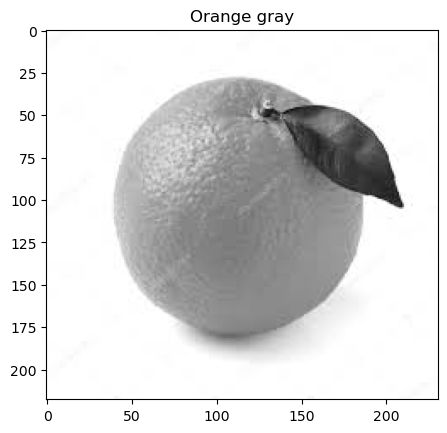

Orange shape: (218, 231)


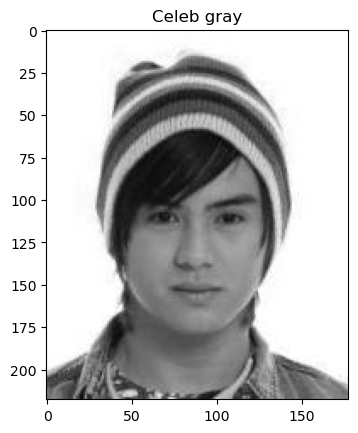

Celeb shape: (218, 178)


In [9]:
# set images pathes
orange_path = '../data/orange.jpeg'
celeb_path = '../data/celeb.jpeg'
# read imgs
img_orange = cv.imread(orange_path, cv.IMREAD_GRAYSCALE)
img_celeb = cv.imread(celeb_path, cv.IMREAD_GRAYSCALE)

display_image('Orange gray', img_orange)
print(f"Orange shape: {img_orange.shape}")
display_image('Celeb gray', img_celeb)
print(f"Celeb shape: {img_celeb.shape}")

* Create a 7 × 7 Gaussian kernel with sigma=1.

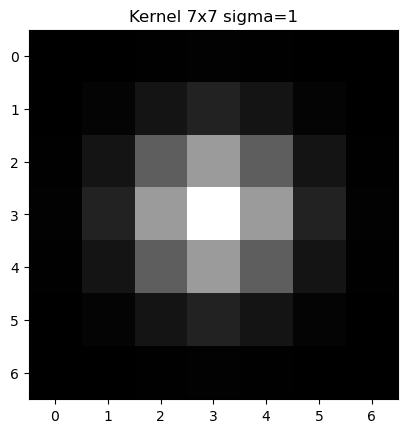

In [10]:

kernel_size = 7
kernel = kernel = cv.getGaussianKernel(kernel_size, 1)
kernel_2d = kernel * kernel.T

display_image('Kernel 7x7 sigma=1', kernel_2d)

In [11]:
def blur_im_spatial(image, kernel):
    """
    Blurs the image using spatial filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    return cv.filter2D(image,  -1, kernel=kernel_2d).astype(np.uint8)


* Blur the images by convolving the image with the Gaussian kernel directly in
the spatial domain. You may use the library function (cv2.filter2D).

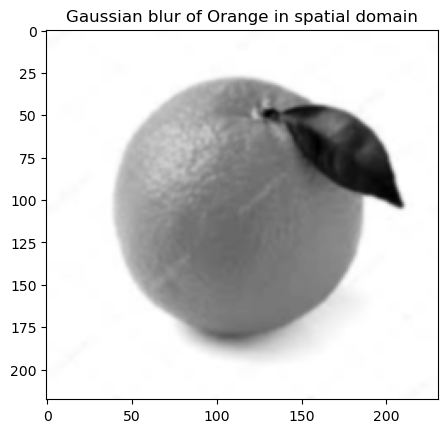

In [12]:
start = time.perf_counter()
blur_img_orange_spatial = blur_im_spatial(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_spatial_time = end - start
display_image('Gaussian blur of Orange in spatial domain', blur_img_orange_spatial)

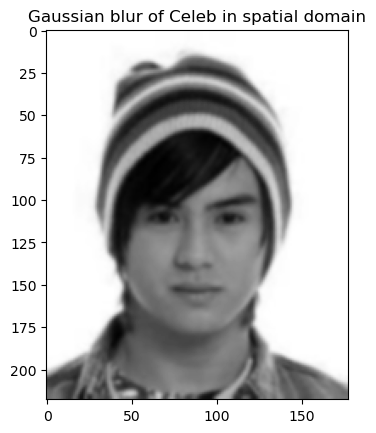

In [13]:
start = time.perf_counter()
blur_img_celeb_spatial = blur_im_spatial(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_spatial_time = end - start
display_image('Gaussian blur of Celeb in spatial domain', blur_img_celeb_spatial)

* Now we are going to blur the images in the frequency domain using Fourier
Transform. We multiply the kernel function and the frequency image instead
of applying convolution. To get the final result, we transform back to the image
space. You may use functions included in the package numpy.fft to apply the
transform and its inverse.

In [14]:
# blur the image in the frequency domain
def blur_im_freq(image, kernel):
   
    # compute fft of image
    fft_image = np.fft.fft2(image)
    # compute fft of kernel with the same shape as image
    fft_kernel = np.fft.fft2(kernel, s=image.shape)
    fft_kernel_shift = np.fft.fftshift(fft_kernel)
    display_image('FFT of kernel', np.log(np.abs(fft_kernel_shift)))
    # compute convolution in frequency domain
    fft_result = fft_image * fft_kernel
    # compute inverse fft
    result = np.fft.ifft2(fft_result)
    # return real part of the result
    return np.abs(result).astype(np.uint8)

In [15]:
def blur_im_freq(image, kernel):
    """
    Blurs the image using frequency filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    image_height, image_width = image.shape
    kern_height, kern_width = kernel.shape
    # compute padding to make kernel shape equal to image shape
    padding_top = image_height // 2 - kern_height // 2
    padding_botton = image_height // 2 - kern_height // 2 - 1
    padding_left = image_width // 2 - kern_width // 2
    padding_right = image_width // 2 - kern_width // 2 - 1


    if(image_width % 2 == 1):
        padding_right += 1 
    # add padding to kernel
    padded_kernel = np.pad(
        kernel, pad_width=((padding_top, padding_botton), (padding_left, padding_right)),
        mode="constant", constant_values=0
    )

    # compute fft of image
    image_freq = np.fft.fft2(image)
    # compute fft of padded kernel 
    kernel_freq = np.fft.fft2(padded_kernel)
    # display_image('FFT of kernel', np.log(np.abs(kernel_freq)))
    # compute convolution in frequency domain
    fft_result_freq = image_freq * kernel_freq
    # compute inverse fft
    fft_result = np.fft.ifft2(fft_result_freq)

    # fixing the shift
    fft_result = np.fft.fftshift(fft_result)
    # return real part of the result
    fft_result = np.abs(fft_result).clip(min=0, max=255)  # clipping to [0, 255] because of numerical errors the max values are slightly above 255

    # ??? casting to uint8 is not needed because of clipping, but if I cast to uint8, it makes the difference between spatial and frequency domain higher ???
    # I dont understand Why

    return fft_result

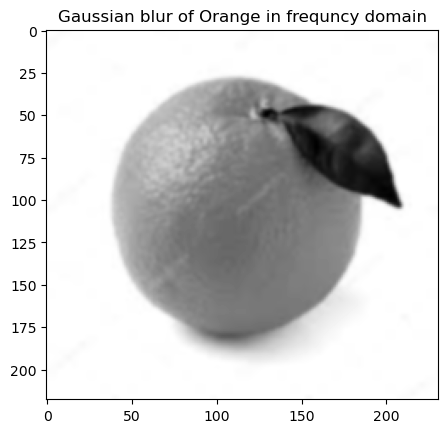

In [16]:
start = time.perf_counter()
blur_img_orange_frequency = blur_im_freq(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_freq_time = end - start
display_image('Gaussian blur of Orange in frequncy domain', blur_img_orange_frequency)

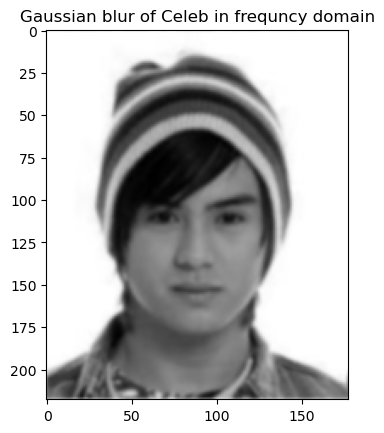

In [17]:
start = time.perf_counter()
blur_img_celeb_frequency = blur_im_freq(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_freq_time = end - start
display_image('Gaussian blur of Celeb in frequncy domain', blur_img_celeb_frequency)

* Visualise the results for both images and report the mean absolute difference
between the two blurring methods and the time taken by each of them.

In [18]:
def difference_between(im_1,im_2):
    """
    Computes the absolute difference and
    mean absolute difference between two images.
    """
    diff = np.abs(np.subtract(im_1.astype(np.float32), im_2.astype(np.float32)))
    mean_diff = np.mean(diff)
    return diff, mean_diff

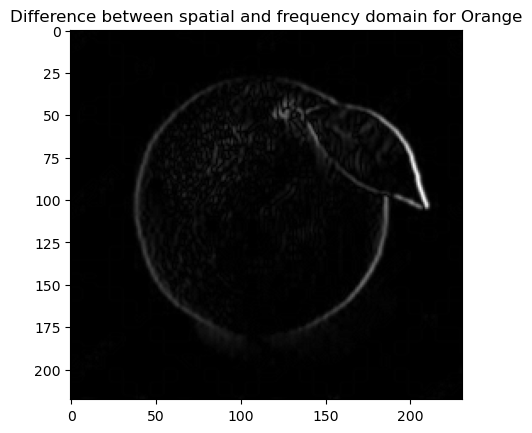

Orange mean difference: 1.357424259185791


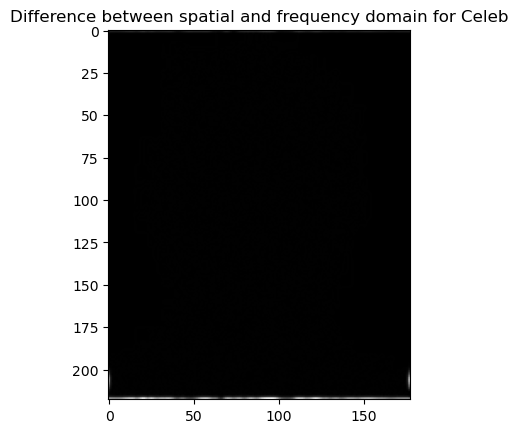

Celeb mean difference: 1.357424259185791

Orange spatial time: 0.00588989999999967
Orange frequency time: 0.014116300000011961
Celeb spatial time: 0.0004938000000151987
Celeb frequency time: 0.014758999999997968


In [19]:
orange_diff, orange_mean_diff = difference_between(blur_img_orange_spatial, blur_img_orange_frequency)
celeb_diff, celeb_mean_diff = difference_between(blur_img_celeb_spatial, blur_img_celeb_frequency)

display_image('Difference between spatial and frequency domain for Orange', orange_diff)
print(f"Orange mean difference: {orange_mean_diff}")
display_image('Difference between spatial and frequency domain for Celeb', celeb_diff)
print(f"Celeb mean difference: {orange_mean_diff}")
print()

print(f"Orange spatial time: {orange_spatial_time}")
print(f"Orange frequency time: {orange_freq_time}")

print(f"Celeb spatial time: {celeb_spatial_time}")
print(f"Celeb frequency time: {celeb_freq_time}")
